In [ ]:
"""
implement vgg16
dataset: cifar-10
"""
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import dataloader, Subset

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from pathlib import Path
import os

try:
   from torchinfo import summary
except:
    !pip3 install torchinfo
    from torchinfo import summary


In [73]:
# device agnoistic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
device


'cuda'

In [74]:
# hyperparameter
BATCH_SIZE = 64
EPOCHS = 20
NUM_WORKERS = 4

In [75]:
# get dataset
transform = transforms.Compose([
    transforms.Resize(size=(32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
train_data = datasets.CIFAR10(
    root='data',
    train=True,
    transform=transform,
    download=True)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [76]:
num_classes = len(train_data.classes)
num_classes

10

(<matplotlib.image.AxesImage at 0x79a0ac657820>,
 torch.Size([3, 32, 32]),
 'truck')

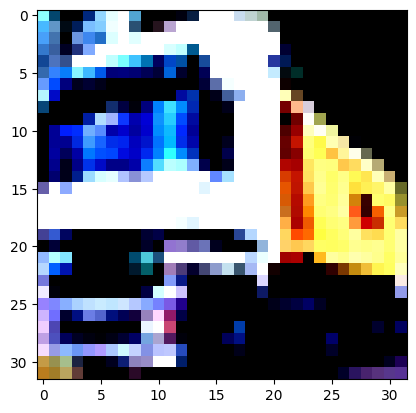

In [77]:
img, label = train_data[1]
plt.imshow(img.permute(1,2,0)), img.shape, train_data.classes[label]

In [78]:
# turn dataset into dataloader
train_dataloader = dataloader.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True)
test_dataloader = dataloader.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True)

img, label = train_dataloader.dataset[0]
img.shape, label

(torch.Size([3, 32, 32]), 6)

In [79]:
img, label = next(iter(train_dataloader))
label.shape, label.dtype
img.shape

torch.Size([64, 3, 32, 32])

In [80]:
# build model
"""
vgg16 (64-128-256-512 -4096)
kernel = 3
conv-conv-pool, conv-conv-pool, conv-conv-conv-pool, conv-conv-conv-pool, conv-conv-conv-pool, fc-fc-fc
"""

class vgg16(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        # block 1
        self.vgg_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


        # block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


        # block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


        # block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


        # block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        # fully connect
        self.vgg_classifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=output_shape)
            )
    def forward(self, x):
        x = self.vgg_block(x)
        #print(x.shape)
        x = self.vgg_classifier(x)
        #print(x.shape)
        return x

In [81]:
vggmodel = vgg16(3, num_classes).to(device)

summary(vggmodel)


Layer (type:depth-idx)                   Param #
vgg16                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [82]:
dummy_img, label = next(iter(train_dataloader)) # need shape[B, C, H, Ws]
dummy_img.shape

torch.Size([64, 3, 32, 32])

In [83]:

vggmodel(dummy_img.to(device))

tensor([[ 1.3978e-02, -9.1175e-04,  3.4524e-03,  4.2594e-03, -1.6110e-02,
         -8.7649e-03, -3.6237e-03,  7.4589e-03, -4.0535e-03,  8.6255e-03],
        [ 1.4956e-02, -2.3116e-03,  5.1636e-03,  4.1929e-03, -1.5437e-02,
         -5.9776e-03, -4.4413e-03,  1.0441e-02, -3.4667e-03,  7.8545e-03],
        [ 1.7612e-02, -4.8002e-05,  3.3749e-03,  4.2137e-03, -1.5501e-02,
         -8.4214e-03, -3.8210e-03,  9.7402e-03, -3.5846e-03,  7.3002e-03],
        [ 1.7299e-02, -5.2130e-04,  3.0149e-03,  5.6885e-03, -1.5455e-02,
         -8.4719e-03, -4.9071e-03,  8.4290e-03, -3.3439e-03,  7.9338e-03],
        [ 1.4826e-02,  9.6649e-05,  3.2822e-03,  3.5652e-03, -1.5077e-02,
         -6.9136e-03, -4.0733e-03,  9.0735e-03, -2.7707e-03,  7.8918e-03],
        [ 1.4579e-02, -2.2424e-04,  4.8084e-03,  4.2948e-03, -1.5291e-02,
         -6.5051e-03, -5.7605e-03,  9.0164e-03, -3.6512e-03,  1.0649e-02],
        [ 1.5839e-02,  7.4120e-04,  5.4284e-03,  3.6138e-03, -1.5597e-02,
         -6.8893e-03, -4.0073e-0

In [84]:
# train func
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # forward
        y_logits = model(X)
        #print(f'output shape: {y_logits.shape}')

        # loss and accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        y_label = y_logits.argmax(dim=1)
        accuracy = (y_label == y).sum().item() / len(y)
        train_acc += accuracy

        # zero grad
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # gd
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc



In [85]:
# test func
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # forward
            test_logits = model(X)
            # loss and acc
            loss = loss_fn(test_logits, y)
            test_loss += loss.item()

            test_label = test_logits.argmax(dim=1)
            test_acc += (test_label == y).sum().item() / len(y)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc

In [86]:
# train and test
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,device):
    torch.cuda.empty_cache()
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        #if epoch%5==0:
        print(f'[{epoch+1}/{epochs}] | train loss: {train_loss:.4f}, train acc: {train_acc*100:.2f}% | test loss: {test_loss:.4f}, test acc: {test_acc*100:.2f}%')
        torch.cuda.empty_cache()
    return results



In [87]:
'''
train_data = Subset(train_data, range(1000))
test_data = Subset(test_data, range(200))
'''
train_dataloader = dataloader.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = dataloader.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [88]:
import torchvision.models as models
vggmodel = vgg16(3, num_classes).to(device)
pre_model = models.vgg16(pretrained=True)
vggmodel.load_state_dict(pre_model.state_dict(), strict=False)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vggmodel.parameters(), lr=0.001)
# get result
result_dict = train(vggmodel, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=EPOCHS, device=device)


  0%|          | 0/20 [00:00<?, ?it/s]

[1/20] | train loss: 2.0946, train acc: 16.18% | test loss: 1.8811, test acc: 22.55%
[2/20] | train loss: 1.7880, train acc: 26.98% | test loss: 1.6171, test acc: 33.18%
[3/20] | train loss: 1.5605, train acc: 37.61% | test loss: 1.4974, test acc: 42.04%
[4/20] | train loss: 1.3809, train acc: 47.93% | test loss: 1.4040, test acc: 48.52%
[5/20] | train loss: 1.2043, train acc: 56.14% | test loss: 1.1923, test acc: 56.87%
[6/20] | train loss: 1.0627, train acc: 62.37% | test loss: 1.0910, test acc: 62.54%
[7/20] | train loss: 0.9790, train acc: 65.95% | test loss: 0.9804, test acc: 67.15%
[8/20] | train loss: 0.8957, train acc: 69.26% | test loss: 0.9754, test acc: 65.86%
[9/20] | train loss: 0.8389, train acc: 71.71% | test loss: 0.9330, test acc: 68.92%
[10/20] | train loss: 0.7834, train acc: 74.11% | test loss: 0.9528, test acc: 69.29%
[11/20] | train loss: 0.7211, train acc: 76.19% | test loss: 0.8864, test acc: 70.99%
[12/20] | train loss: 0.6824, train acc: 77.66% | test loss: 0.

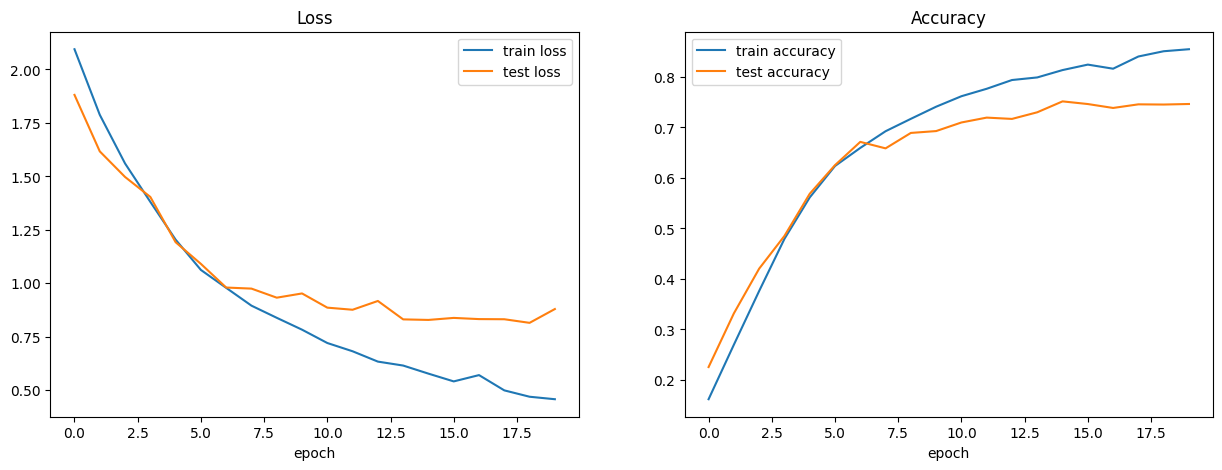

In [89]:
from typing import Dict, List
def plot_loss_curve(results: Dict[str, List[float]]):
    results = pd.DataFrame(results)
    train_loss = results['train_loss']
    train_acc = results['train_acc']
    test_loss = results['test_loss']
    test_acc = results['test_acc']
    plt.figure(figsize=(15,5))
    epoch = range(len(results))
    plt.subplot(1,2,1)
    plt.plot(epoch, train_loss, label='train loss')
    plt.plot(epoch, test_loss, label='test loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch, train_acc, label='train accuracy')
    plt.plot(epoch, test_acc, label='test accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.legend()

plot_loss_curve(result_dict)

In [ ]:
from pathlib import Path
path_name = Path('models')
path_name.mkdir(parents=True, exist_ok=True)

model_name = 'vgg16model.pth'
model_path = path_name / model_name
print(f'save model to {model_path}')
torch.save(obj=vggmodel.state_dict(), f=model_path)

save model to models/vgg16model.pth
